In [44]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

Populating the interactive namespace from numpy and matplotlib


C:\Programs\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Данные о пассажирских авиаперевозках
# Международные пассажирские авиаперевозки 
# В тысячах человек, по месяцам
# С января 1949 по декабрь 1960 года.
# Название файла с данными series_g.csv


Сделаем ресемпл данных, чтобы лучше видеть, как обучается модель.

In [45]:
data = pd.read_csv('series_g.csv', sep=";")
data

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121
...,...,...
139,AUG 1960,606
140,SEP 1960,508
141,OCT 1960,461
142,NOV 1960,390


In [46]:
data["date"] = pd.to_datetime(data["date"])
data

,date,series_g
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


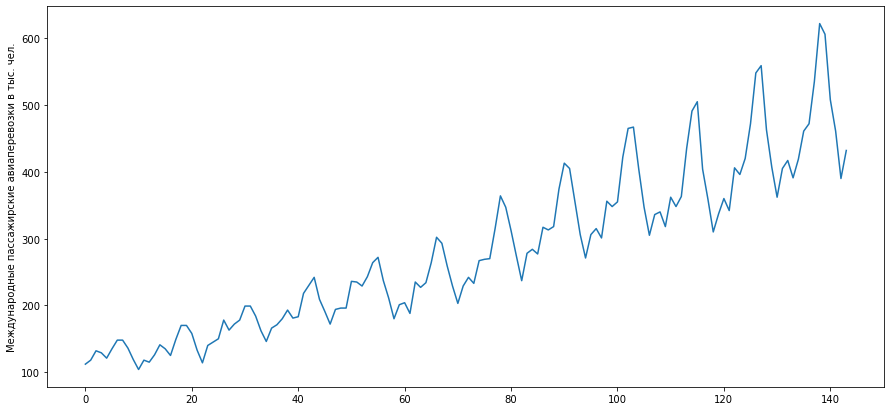

In [47]:
plt.figure(figsize(15,7))
data['series_g'].plot()
plt.ylabel('Международные пассажирские авиаперевозки в тыс. чел.')
pylab.show()

### Разбиваем данные для обучения модели

In [48]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

### Linear regression

In [49]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(data['series_g'], test_size=0.3, lag_start=0, lag_end=12)
X_train = X_train[11:]
y_train = y_train[11:]

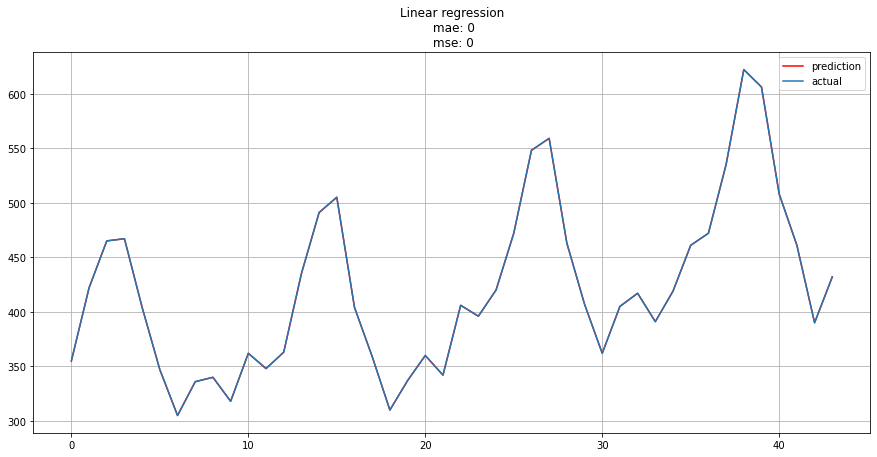

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n mae: {}\n mse: {}".format(round(mean_absolute_error(prediction, y_test)), round(mean_squared_error(prediction, y_test))))
plt.grid(True);

## Попробуем xgboost

In [55]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.3, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data['series_g'], lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1500

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('mae'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-mae-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-mae-mean'].argmin()]["test-mae-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train, label='prediction')
    plt.plot(y_train, label='y_train')
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost mae: {}\n mse: {}".format(round(mean_absolute_error(prediction_test, y_test)), round(mean_squared_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend

[13:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

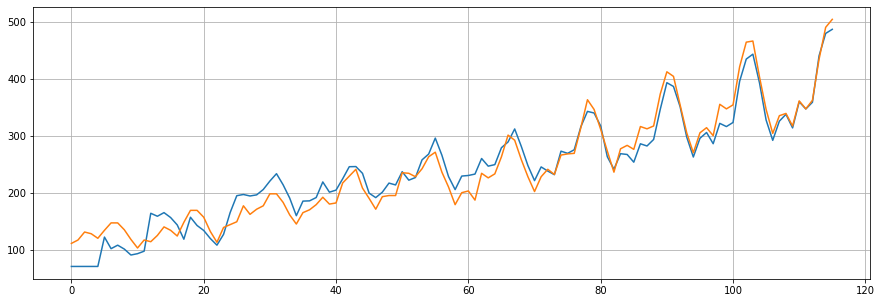

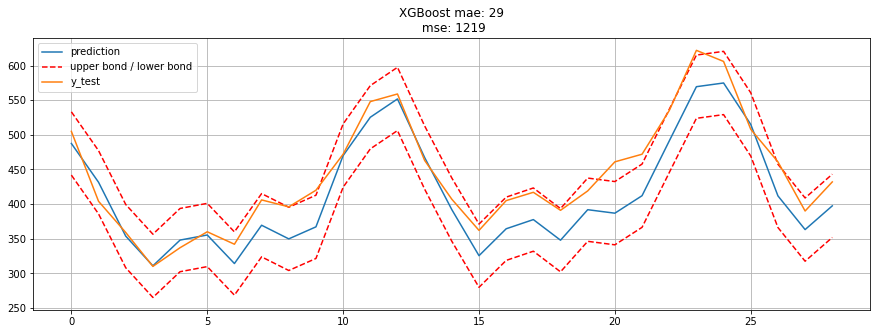

In [56]:
XGB_forecast(data, test_size=0.2, lag_start=5, lag_end=30)